## 📌 DACON 전복 나이 예측 경진 대회
전복 데이터를 이용해 전복의 나이를 예측해주세요! 주어진 데이터 이외의 데이터는 사용 금지!

### 1. 평가
```python
import numpy as np

def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score
```

- public score : 전체 테스트 데이터 중 50%
- private score : 전체 테스트 데이터 중 50%

## 📌 데이터
1. train
- id : id
- Gender : 성별
- Lenght : 길이
- Diameter : 둘레
- Height : 키
- Whole Weight : 전체 무게
- Shucked Weight : 껍질을 제외한 무게 (전복 무게)
- Viscra Weight : 내장 무게
- Shell Weight : 껍질 무게
- Target : 나이 (목표변수)

2. test
3. submission

## 📌 라이브러리 및 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])

import warnings
warnings.filterwarnings('ignore')

import multiprocessing
import os

In [2]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR, LinearSVR
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance, plot_tree
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm import plot_importance, plot_metric, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

In [72]:
train = pd.read_csv('C:/data/train1.csv')
test = pd.read_csv('C:/data/test.csv')
submission = pd.read_csv('C:/data/sample_submission.csv')

- train, test의 컬럼명에 오타 변경

In [73]:
train.rename(columns={'Lenght' : 'Length'}, inplace=True)
test.rename(columns={'Lenght' : 'Length'}, inplace=True)

In [46]:
train

,id,Gender,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,1,M,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,15
1,2,I,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,8
2,3,I,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,18
3,4,M,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,13
4,5,I,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,6
...,...,...,...,...,...,...,...,...,...,...
1248,1249,I,0.190,0.145,0.040,0.0380,0.0165,0.0065,0.0150,4
1249,1250,I,0.395,0.310,0.085,0.3170,0.1530,0.0505,0.0935,7
1250,1251,F,0.525,0.410,0.115,0.7745,0.4160,0.1630,0.1800,7
1251,1252,F,0.445,0.335,0.110,0.4355,0.2025,0.1095,0.1195,6


In [47]:
test

,id,Gender,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight
0,1,F,0.595,0.470,0.155,1.1210,0.4515,0.1780,0.1550
1,2,M,0.580,0.450,0.150,0.9270,0.2760,0.1815,0.3600
2,3,I,0.260,0.205,0.070,0.0970,0.0415,0.0190,0.0305
3,4,M,0.590,0.460,0.130,1.1020,0.4550,0.2055,0.3300
4,5,F,0.595,0.465,0.140,1.1130,0.5175,0.2440,0.3050
...,...,...,...,...,...,...,...,...,...
2919,2920,I,0.170,0.105,0.035,0.0340,0.0120,0.0085,0.0050
2920,2921,I,0.435,0.345,0.115,0.4180,0.2220,0.0735,0.1060
2921,2922,I,0.570,0.450,0.135,0.7940,0.3815,0.1415,0.2450
2922,2923,I,0.460,0.350,0.120,0.4885,0.1930,0.1050,0.1550


In [48]:
print(train.shape)
print(test.shape)

(1253, 10)
(2924, 9)


- train 데이터 셋의 양이 훨씬 적다

<AxesSubplot:>

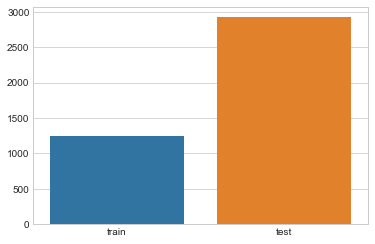

In [49]:
x = ['train', 'test']
y = [train.shape[0], test.shape[0]]
sns.barplot(x=x, y=y)

## 📌 EDA

In [50]:
train.info()  # 데이터 정보

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1253 non-null   int64  
 1   Gender          1253 non-null   object 
 2   Length          1253 non-null   float64
 3   Diameter        1253 non-null   float64
 4   Height          1253 non-null   float64
 5   Whole Weight    1253 non-null   float64
 6   Shucked Weight  1253 non-null   float64
 7   Viscra Weight   1253 non-null   float64
 8   Shell Weight    1253 non-null   float64
 9   Target          1253 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 98.0+ KB


In [74]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [52]:
train.describe()  # 요약통계량

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
count,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000
mean,0.522869,0.406963,0.139545,0.831199,0.358818,0.181006,0.240077,9.912211
std,0.120231,0.099771,0.039033,0.500491,0.224612,0.111936,0.142574,3.214676
min,0.110000,0.090000,0.030000,0.008000,0.002500,0.002000,0.003000,3.000000
25%,0.445000,0.345000,0.115000,0.440500,0.182500,0.092500,0.130000,8.000000
50%,0.535000,0.420000,0.140000,0.777500,0.326000,0.168000,0.230000,10.000000
75%,0.615000,0.480000,0.165000,1.160000,0.505500,0.256500,0.330000,11.000000
max,0.780000,0.630000,0.250000,2.779500,1.488000,0.760000,1.005000,29.000000


- Target 데이터의 값이 9~10을 중심으로 많이 분포되어 있고, 15 이후로는 값이 적다.
- Oversampling 필요해 보인다.

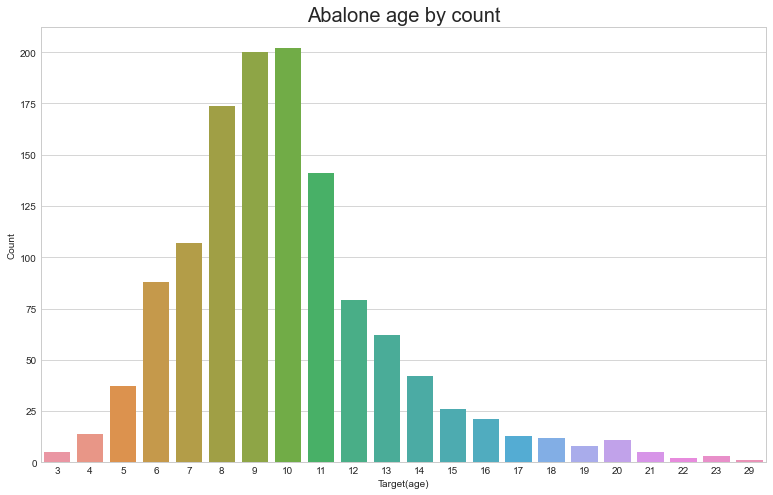

In [13]:
plt.figure(figsize=(13, 8))
sns.countplot('Target', data=train)
plt.xlabel("Target(age)")
plt.ylabel("Count")
plt.title("Abalone age by count", fontsize=20)
plt.show()

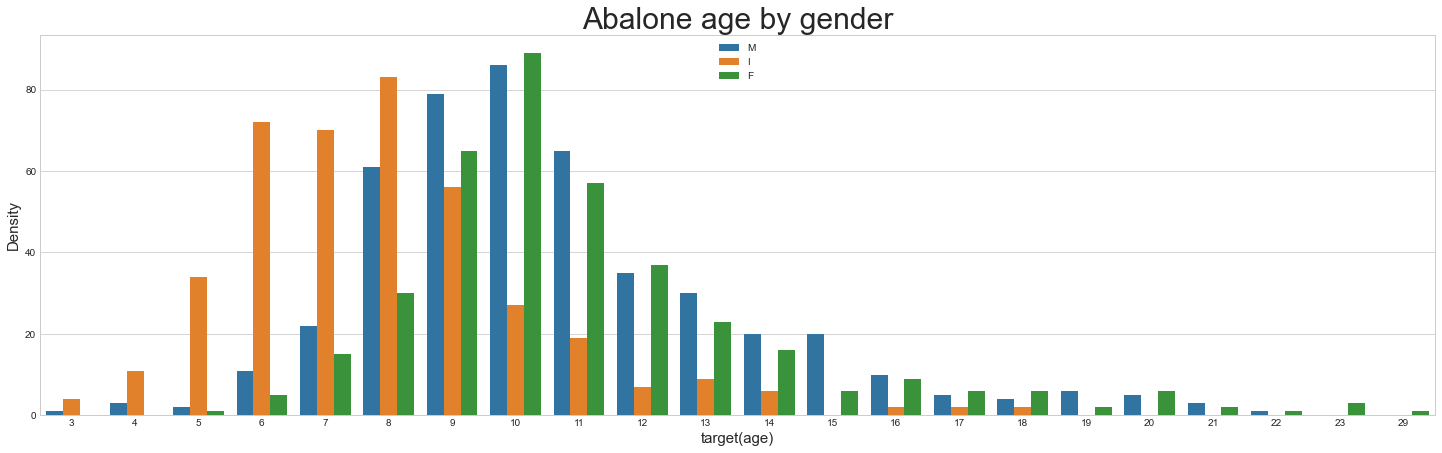

In [13]:
plt.rcParams['figure.figsize'] = [25,7]
sns.countplot('Target', hue='Gender', data=train)
plt.title('Abalone age by gender', fontsize=30)
plt.xlabel('target(age)', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend()
plt.show()

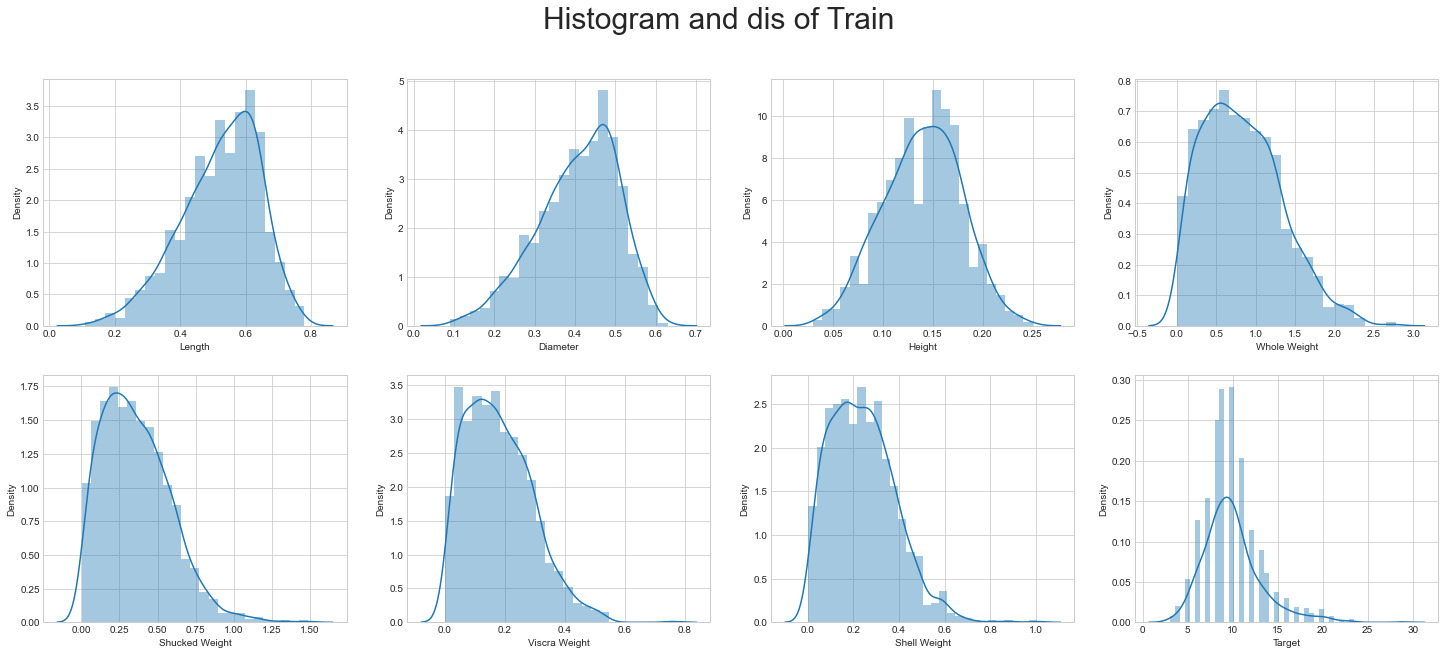

In [14]:
col = train.columns[1:]
fig, ax = plt.subplots(2, 4, figsize=(25, 10))

ax = ax.flatten()
for i, col in enumerate(train.columns[1:]):
        sns.distplot(train[col], ax=ax[i])
        
plt.suptitle("Histogram and dis of Train", fontsize=30)
plt.show()

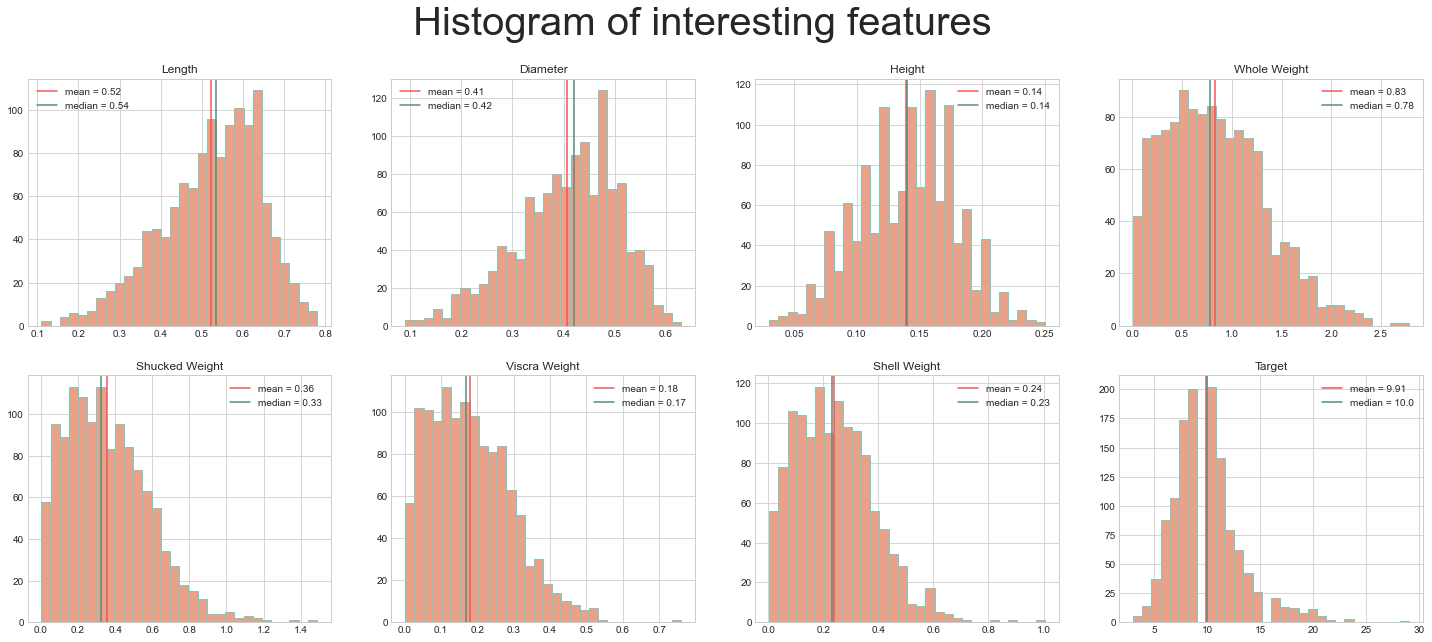

In [15]:
description = train.describe()
columns = train.columns[1:]

fig, ax = plt.subplots(2, 4, figsize = (25, 10))
fig.suptitle('Histogram of interesting features', fontsize=40)
idx = 0
for i in range(2):
    for j in range(4):
        ax[i][j].hist(train[columns[idx]], bins=30, color='#eaa18a', edgecolor='#7bcabf')
        ax[i][j].set_title(columns[idx])
        ax[i][j].axvline(description[columns[idx]]['mean'], c='#f55354',
                         label = f"mean = {round(description[columns[idx]]['mean'], 2)}")
        ax[i][j].axvline(description[columns[idx]]['50%'], c='#518d7d',
                         label = f"median = {round(description[columns[idx]]['50%'], 2)}")
        ax[i][j].legend()
        idx += 1

<AxesSubplot:xlabel='Gender', ylabel='count'>

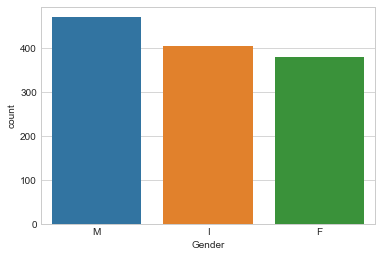

In [24]:
sns.countplot('Gender', data=train)

- 상대적으로 Gender == I인 값들의 분포가 낮다.

<AxesSubplot:xlabel='Gender', ylabel='Target'>

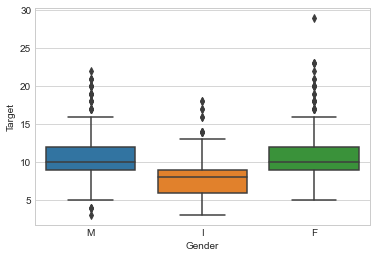

In [31]:
sns.boxplot(x='Gender', y='Target', data=train)

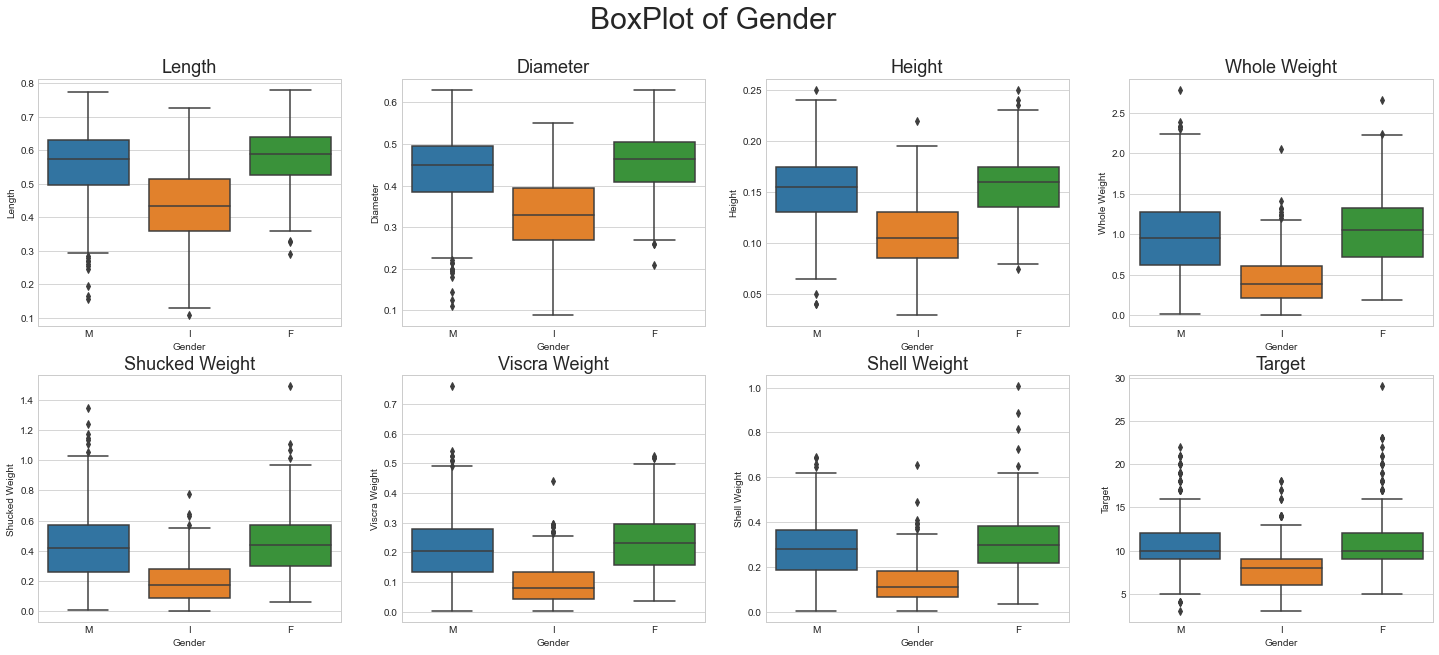

In [34]:
col = train.columns[1:]
fig, ax = plt.subplots(2, 4, figsize=(25, 10))

ax = ax.flatten()
for i, col in enumerate(train.columns[1:]):
        sns.boxplot('Gender', train[col], ax=ax[i], data=train)
        ax[i].set_title(col, fontsize=18)
plt.suptitle("BoxPlot of Gender", fontsize=30)
plt.show()

- 공통적으로 Target 값이 25보다 큰 이상치가 보임

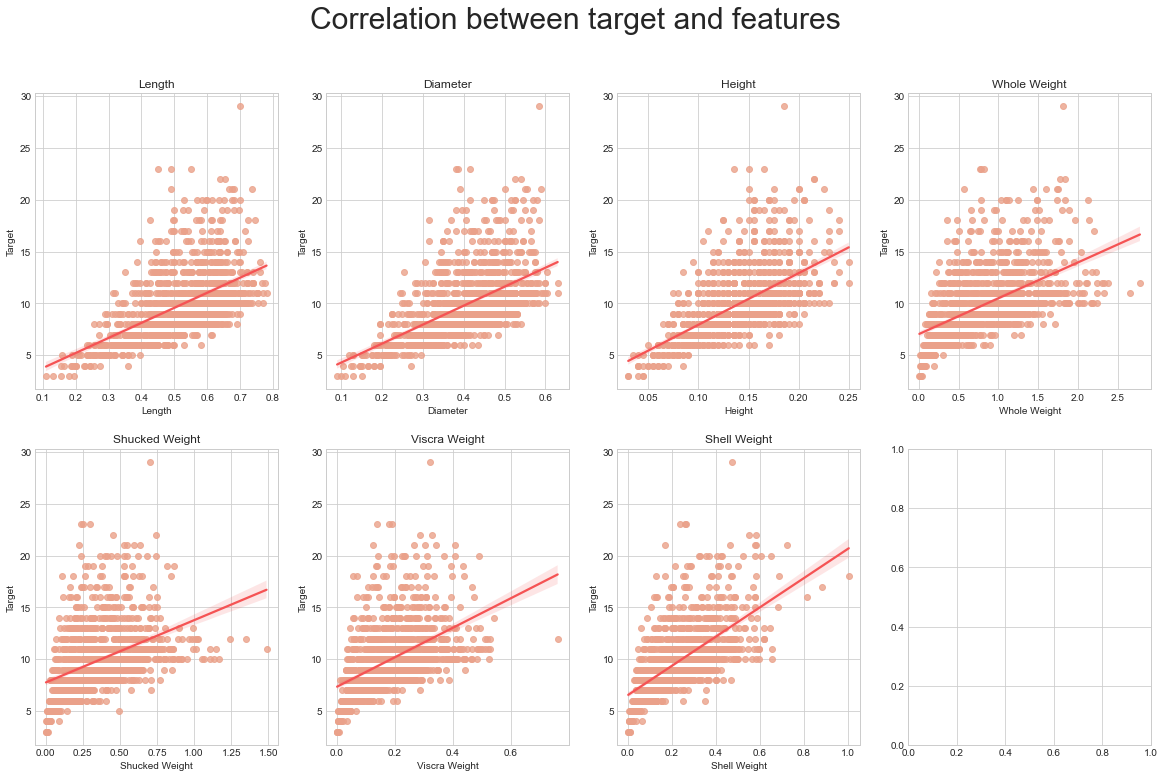

In [54]:
def visualize(axx, col):
  # regplot을 이용하여 추세선과 산점도 그래프를 그려줍니다.
  sns.regplot(x=col, y='Target', data=train,  color='#eaa18a', line_kws={'color': '#f55354'} , ax = axx)
  axx.set_title(col)

figure, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4, figsize=(20, 12))
figure.suptitle('Correlation between target and features', fontsize=30)

for i in range(len(train.columns[1:-1])):
  visualize(eval(f'ax{i+1}'), train.columns[i+1])

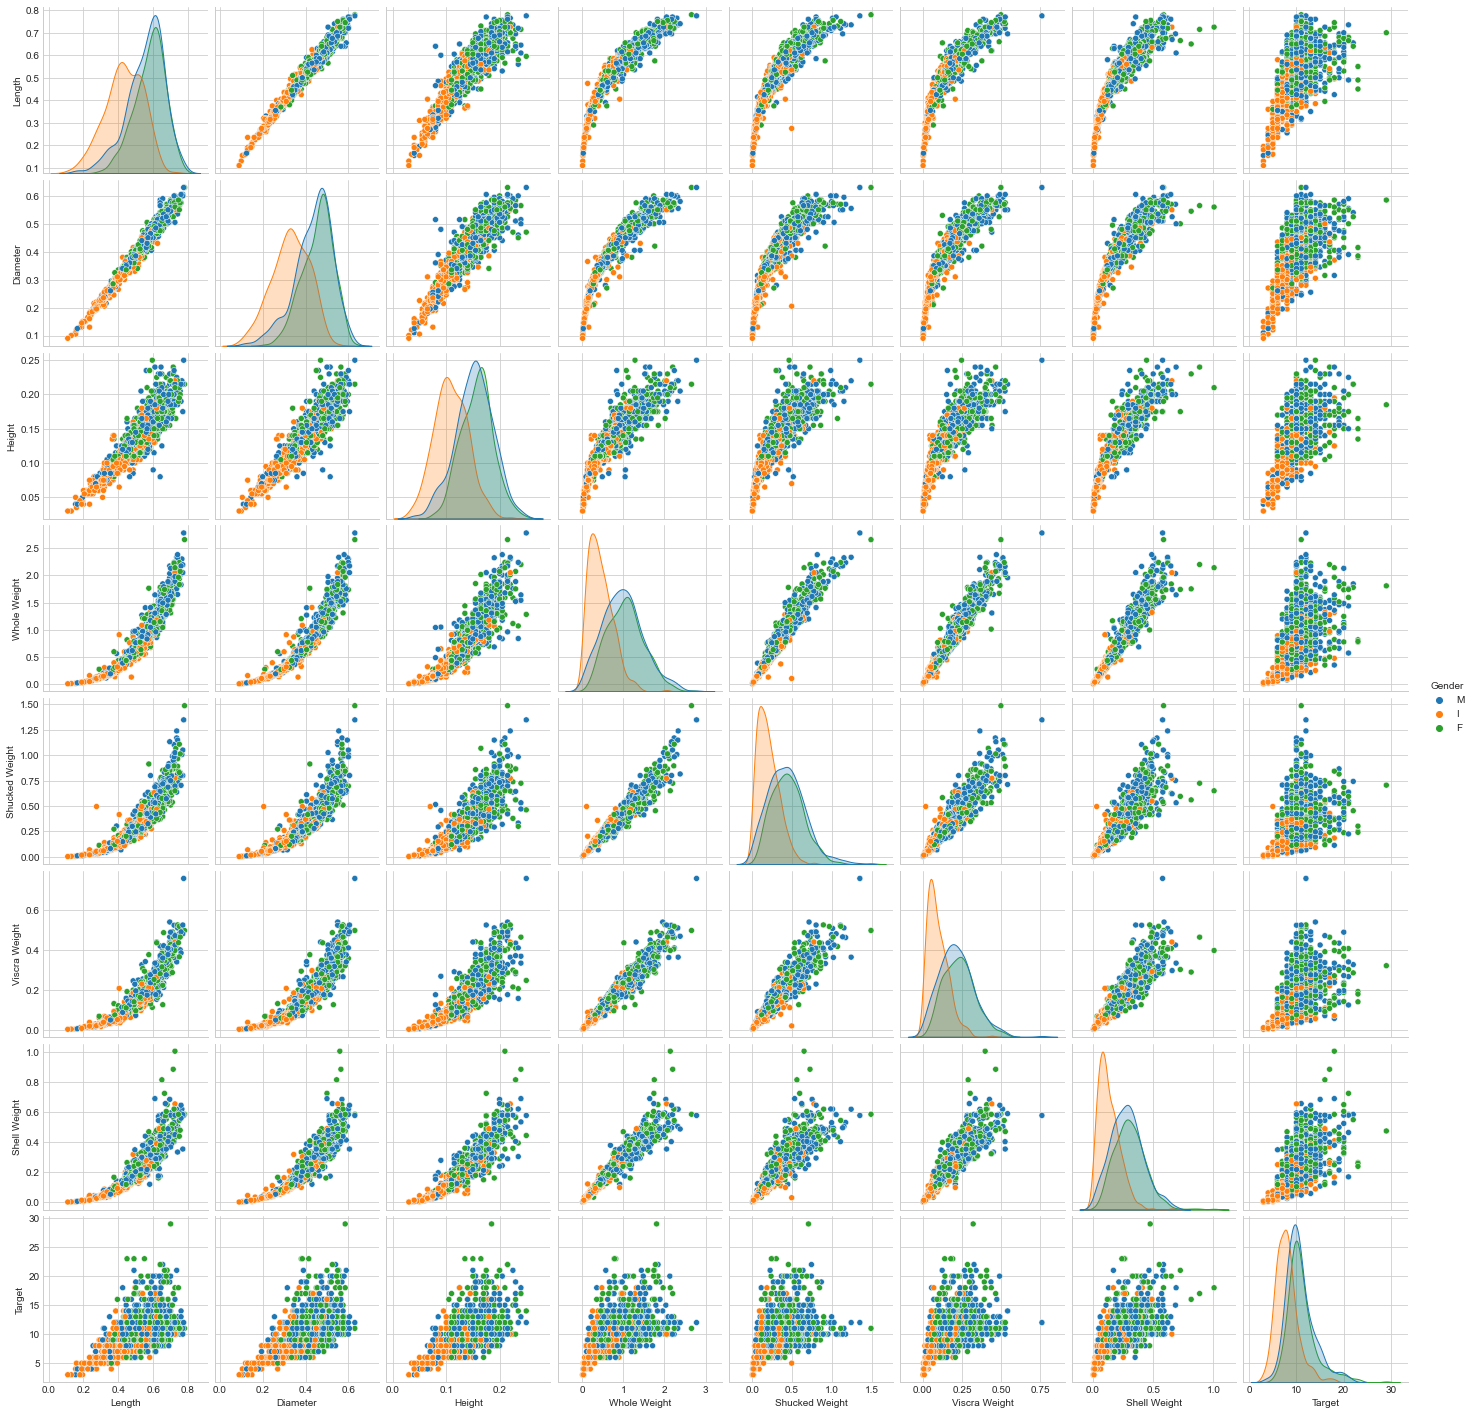

In [35]:
sns.pairplot(train[list(train.columns[1:]) + ['Gender']], hue="Gender")

In [14]:
corr = train.corr()
corr

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
Length,1.000000,0.987293,0.901911,0.926321,0.896337,0.903732,0.895664,0.543789
Diameter,0.987293,1.000000,0.908348,0.927205,0.891183,0.901029,0.904546,0.567933
Height,0.901911,0.908348,1.000000,0.895409,0.837456,0.868192,0.902180,0.604654
Whole Weight,0.926321,0.927205,0.895409,1.000000,0.968007,0.966942,0.951652,0.538404
Shucked Weight,0.896337,0.891183,0.837456,0.968007,1.000000,0.932138,0.870453,0.420126
Viscra Weight,0.903732,0.901029,0.868192,0.966942,0.932138,1.000000,0.905061,0.497283
Shell Weight,0.895664,0.904546,0.902180,0.951652,0.870453,0.905061,1.000000,0.625819
Target,0.543789,0.567933,0.604654,0.538404,0.420126,0.497283,0.625819,1.000000


In [15]:
corr_sorted = corr[['Target']].sort_values(by='Target', ascending=False).drop(['Target'], axis=0)
corr_sorted

,Target
Shell Weight,0.625819
Height,0.604654
Diameter,0.567933
Length,0.543789
Whole Weight,0.538404
Viscra Weight,0.497283
Shucked Weight,0.420126


Text(0.5, 1.0, 'Correlation between features')

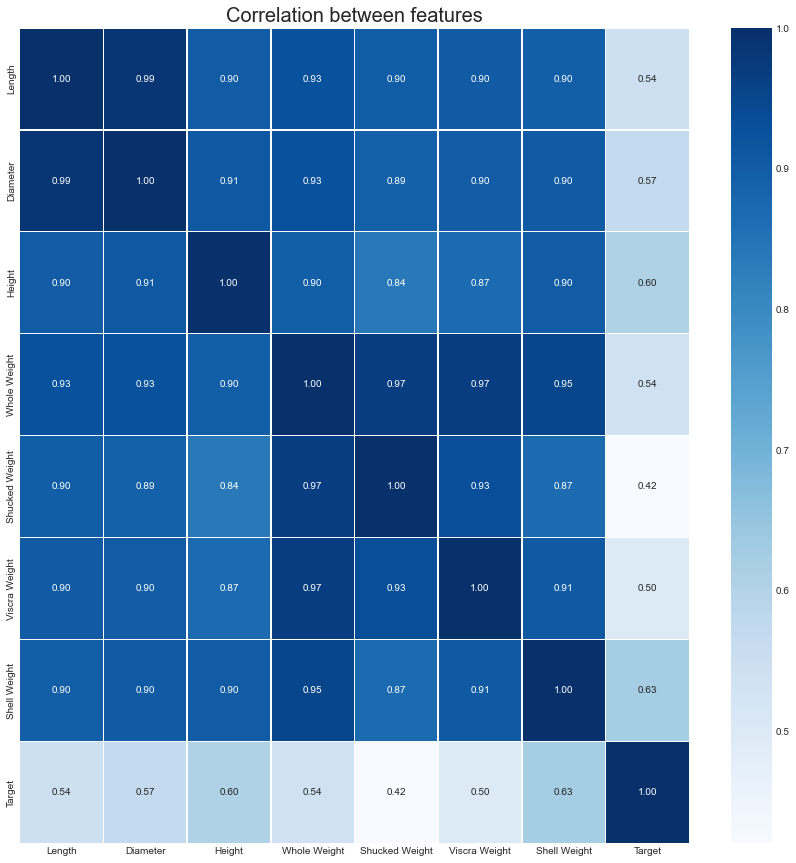

In [48]:
plt.figure(figsize=(15,15))

sns.heatmap(data=corr, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=20)

## 📌 이상치 제거

In [75]:
train[train['Target'] > 25]  # Target = 29 (이상치)

,Gender,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
762,F,0.7,0.585,0.185,1.8075,0.7055,0.3215,0.475,29


In [76]:
train = train.drop(index=[762], axis=0)

### 전복의 전체 무게 < 껍질을 제외한 무게 + 껍질 무게
- 이상치로 간주하고 제거

In [77]:
train[train['Whole Weight'] < (train['Shucked Weight'] + train['Shell Weight'])]  # 이상치

,Gender,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
47,I,0.380,0.275,0.095,0.1375,0.0860,0.0585,0.0605,7
382,I,0.455,0.330,0.100,0.3720,0.3580,0.0775,0.1100,8
435,I,0.475,0.365,0.100,0.1315,0.2025,0.0875,0.1230,7
847,I,0.230,0.165,0.060,0.0515,0.0190,0.0145,0.0360,4
1078,I,0.275,0.205,0.070,0.1055,0.4950,0.0190,0.0315,5


In [78]:
train = train[train['Whole Weight'] >= (train['Shucked Weight'] + train['Shell Weight'])]  # 이상치 제거

### 전복의 무게 < 전복의 내장 무게
- 이상치로 간주하고 제거

In [79]:
train[train['Shucked Weight'] < train['Viscra Weight']]  # 이상치

,Gender,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
465,M,0.415,0.315,0.125,0.388,0.068,0.09,0.125,12


In [80]:
train = train[train['Shucked Weight'] >= train['Viscra Weight']]  # 이상치

## 📌 파생변수
### 1. 물의 무게 = 전체 무게 - (전복 무게 - 껍질 무게)
### 2.  전체 무게 = 전체 무게 - 물의 무게
- 계산해준 후 물의 무게는 train 데이터 셋에서 제거

In [81]:
train['Water'] = train['Whole Weight'] - (train['Shucked Weight'] + train['Shell Weight'])
train['Whole Weight'] = train['Whole Weight'] - train['Water']

In [82]:
train = train.drop(['Water'], axis=1)

- test 데이터 셋에도 동일하게 파생변수 생성

In [83]:
test['Water'] = test['Whole Weight'] - (test['Shucked Weight'] + test['Shell Weight'])
test['Whole Weight'] = test['Whole Weight'] - test['Water']

In [84]:
test = test.drop(['Water'], axis=1)

## 📌 Target Oversampling
### 1. Copy Over Sampling

In [85]:
Target = train['Target']
target = []
for i in range(len(Target)):
    if Target.iloc[i] < 10:
        target.append(1)
    elif Target.iloc[i] < 15:
        target.append(2)
    else:
        target.append(3)
        
train['Range'] = target

- Target이 3(15 이상) 그룹인 값들이 1, 2그룹인 값들에 비해 적다.

<AxesSubplot:xlabel='Range', ylabel='count'>

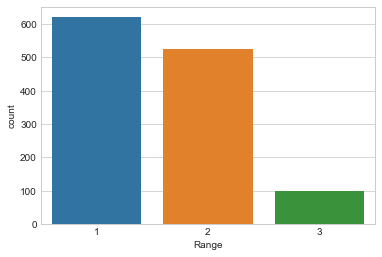

In [86]:
sns.countplot(train['Range'])

In [87]:
train.head()

,Gender,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target,Range
0,M,0.605,0.470,0.115,0.7025,0.3925,0.2910,0.3100,15,3
1,I,0.430,0.315,0.095,0.2795,0.1750,0.0800,0.1045,8,1
2,I,0.580,0.490,0.195,0.9405,0.5305,0.2540,0.4100,18,3
3,M,0.535,0.405,0.175,0.8850,0.5480,0.3265,0.3370,13,2
4,I,0.310,0.235,0.090,0.0880,0.0480,0.0310,0.0400,6,1


In [88]:
train3 = train[train['Range'] == 3]

In [89]:
train = train.append(train3)
train.head()

,Gender,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target,Range
0,M,0.605,0.470,0.115,0.7025,0.3925,0.2910,0.3100,15,3
1,I,0.430,0.315,0.095,0.2795,0.1750,0.0800,0.1045,8,1
2,I,0.580,0.490,0.195,0.9405,0.5305,0.2540,0.4100,18,3
3,M,0.535,0.405,0.175,0.8850,0.5480,0.3265,0.3370,13,2
4,I,0.310,0.235,0.090,0.0880,0.0480,0.0310,0.0400,6,1


<AxesSubplot:xlabel='Range', ylabel='count'>

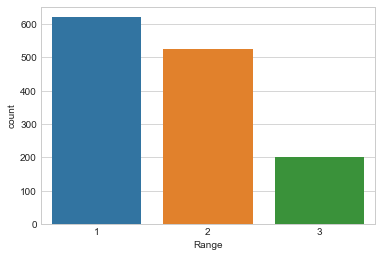

In [21]:
sns.countplot(train['Range'])

In [25]:
train.shape

(1347, 10)

## 📌 범주형 변수 변환

In [90]:
train = pd.get_dummies(data=train, columns=['Gender'])

In [91]:
train.head()

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target,Range,Gender_F,Gender_I,Gender_M
0,0.605,0.470,0.115,0.7025,0.3925,0.2910,0.3100,15,3,0,0,1
1,0.430,0.315,0.095,0.2795,0.1750,0.0800,0.1045,8,1,0,1,0
2,0.580,0.490,0.195,0.9405,0.5305,0.2540,0.4100,18,3,0,1,0
3,0.535,0.405,0.175,0.8850,0.5480,0.3265,0.3370,13,2,0,0,1
4,0.310,0.235,0.090,0.0880,0.0480,0.0310,0.0400,6,1,0,1,0


In [92]:
scaler = MinMaxScaler()
train.iloc[:, :7] = scaler.fit_transform(train.iloc[:, :7])

In [93]:
test = pd.get_dummies(data=test, columns=['Gender'])

In [94]:
test.head()

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Gender_F,Gender_I,Gender_M
0,0.595,0.470,0.155,0.6065,0.4515,0.1780,0.1550,1,0,0
1,0.580,0.450,0.150,0.6360,0.2760,0.1815,0.3600,0,0,1
2,0.260,0.205,0.070,0.0720,0.0415,0.0190,0.0305,0,1,0
3,0.590,0.460,0.130,0.7850,0.4550,0.2055,0.3300,0,0,1
4,0.595,0.465,0.140,0.8225,0.5175,0.2440,0.3050,1,0,0


In [95]:
test.iloc[:, :7] = scaler.fit_transform(test.iloc[:, :7])

## 📌 데이터 나누기

In [96]:
train_X = train.drop(['Target'], axis=1)
train_X.head()

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Range,Gender_F,Gender_I,Gender_M
0,0.738806,0.703704,0.386364,0.336959,0.262538,0.381266,0.306387,3,0,0,1
1,0.477612,0.416667,0.295455,0.132463,0.116123,0.102902,0.101297,1,0,1,0
2,0.701493,0.740741,0.750000,0.452018,0.355436,0.332454,0.406188,3,0,1,0
3,0.634328,0.583333,0.659091,0.425187,0.367216,0.428100,0.333333,2,0,0,1
4,0.298507,0.268519,0.272727,0.039884,0.030629,0.038259,0.036926,1,0,1,0


In [97]:
train_y = train['Target']

## 📌 모델 생성 및 학습

In [98]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [99]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

In [100]:
skf = StratifiedKFold(n_splits=10, random_state=5, shuffle=True)  # 총 15번의 fold 진행
n = 0  # n번째 fold인지 기록

fold_target_pred = []
Range = train_X['Range']
train_X = train_X.drop(['Range'], axis=1)  # #분배된 학습을 위해 만들어둔 Range feature 제거

In [71]:
for train_idx, valid_idx in skf.split(train_X, Range):
    n += 1
    
    val_pred_name = []  # validation pred model 이름 저장
    val_pred = []  # validation set pred 결과 저장
    target_pred = []  # test set pred 결과 저장
    
    train_X = np.array(train_X)
    train_y = np.array(train_y)
    
    X_train, X_valid = train_X[train_idx], train_X[valid_idx]
    y_train, y_valid = train_y[train_idx], train_y[valid_idx]
    
    X_test = np.array(test)
    
    ### Create Model 모델을 생성하고 집어넣는다. ###
    
    ### XGBRegressor ###
    model = XGBRegressor(random_state=5)
    model.fit(X_train, y_train) # 모델 학습
    
    val_pred_name.append("XGBRegressor")      # 모델 이름 저장
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    
    ### DecisionTreeRegressor ###
    model = Ridge(random_state=5)
    model.fit(X_train, y_train) # 모델 학습
    
    val_pred_name.append("Ridge")      # 모델 이름 저장
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    
    ### RandomForestRegressor ###
    model = RandomForestRegressor(random_state=5)
    model.fit(X_train, y_train) # 모델 학습
    
    val_pred_name.append("RandomForestRegressor")      # 모델 이름 저장
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    
    ### SVR ###
    model = SVR()
    model.fit(X_train, y_train) # 모델 학습
    
    val_pred_name.append("SVR")      # 모델 이름 저장
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    
    
    ### voting ###
    
    ### average validation pred ###
    preds = np.array(val_pred[0])
    for i in range(1, len(val_pred)):
        preds += val_pred[i]
    
    preds = preds / len(val_pred)
    
    ### average target pred ###
    target_preds = np.array(target_pred[0])
    for i in range(1, len(target_pred)):
        target_preds += target_pred[i]
        
    target_preds = target_preds / len(target_pred)
    
    fold_target_pred.append(target_preds)  # append final target pred
    
    print("======================== fold %d ========================" %(n))
    for i in range(len(val_pred)):
        print("%s model NMAE : %0.4f" %(val_pred_name[i], NMAE(y_valid, val_pred[i].astype(int))))
    
    print("=========================================================")
    print("Average NMAE %0.4f" %(NMAE(y_valid, preds.astype(int))))
    print("")

======================== fold 1 ========================
XGBRegressor model NMAE : 0.1269
Ridge model NMAE : 0.1683
RandomForestRegressor model NMAE : 0.1318
SVR model NMAE : 0.1837
Average NMAE 0.1438

======================== fold 2 ========================
XGBRegressor model NMAE : 0.1643
Ridge model NMAE : 0.1643
RandomForestRegressor model NMAE : 0.1587
SVR model NMAE : 0.1834
Average NMAE 0.1622

======================== fold 3 ========================
XGBRegressor model NMAE : 0.1300
Ridge model NMAE : 0.1721
RandomForestRegressor model NMAE : 0.1431
SVR model NMAE : 0.1808
Average NMAE 0.1423

======================== fold 4 ========================
XGBRegressor model NMAE : 0.1327
Ridge model NMAE : 0.1739
RandomForestRegressor model NMAE : 0.1384
SVR model NMAE : 0.1732
Average NMAE 0.1441

======================== fold 5 ========================
XGBRegressor model NMAE : 0.1226
Ridge model NMAE : 0.1717
RandomForestRegressor model NMAE : 0.1345
SVR model NMAE : 0.1794
Averag

## 📌 제출

In [43]:
### average target pred ###
final_pred = np.array(fold_target_pred[0])
for i in range(1, len(fold_target_pred)):
    final_pred += fold_target_pred[i]
    
final_pred = final_pred / len(fold_target_pred)
final_pred = final_pred.astype(int)

In [44]:
submission.head()

,id,Target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [45]:
submission['Target'] = final_pred
submission

,id,Target
0,1,7
1,2,12
2,3,6
3,4,9
4,5,9
...,...,...
2919,2920,4
2920,2921,6
2921,2922,8
2922,2923,8


In [205]:
submission.to_csv("submit1.csv", index=False)